In [9]:
!pip install --quiet neural-structured-learning

'pip' is not recognized as an internal or external command,
operable program or batch file.


This is Tensorflow's Neural Structure Learning<br>
https://www.tensorflow.org/neural_structured_learning<br><br>
This is the link with a more in depth look at how it works<br>
https://blog.tensorflow.org/2019/09/introducing-neural-structured-learning.html<br><br>


The basic idea of this library is that it is a new way to train neural networks by using structured signals in conjunction with feature inputs.
Structured signals use graphs to show how samples are related by stating their neighbors and use these relations as input data, where in training 
it is minimizing supervised loss and neighbor loss. This relates to adversarial training, since we can create structures dynamically for input samples
by constructing the structures with adversarial perturbation. <br><br>

This notebook will be following the tutorial provided by Tensorflow.<br>
https://www.tensorflow.org/neural_structured_learning/tutorials/adversarial_keras_cnn_mnist

In [10]:
import matplotlib.pyplot as plt
import neural_structured_learning as nsl
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import seaborn as sns
sns.set()

In [11]:
# These are the hyper params defined for model training and evaluating
class HParams(object):
  def __init__(self):
    self.input_shape = [28, 28, 1]
    self.num_classes = 10
    self.conv_filters = [32, 64, 64]
    self.kernel_size = (3, 3)
    self.pool_size = (2, 2)
    self.num_fc_units = [64]
    self.batch_size = 32
    self.epochs = 5
    self.adv_multiplier = 0.2
    self.adv_step_size = 0.2
    self.adv_grad_norm = 'infinity'

HPARAMS = HParams()

In [12]:
# Here we load the MNIST dataset (Goal later on is to adapt this code with other datasets)
datasets = tfds.load('mnist')

train_dataset = datasets['train']
test_dataset = datasets['test']

IMAGE_INPUT_NAME = 'image'
LABEL_INPUT_NAME = 'label'

In [13]:
# Here we normalize the pixel values to [0, 1]
def normalize(features):
  features[IMAGE_INPUT_NAME] = tf.cast(
      features[IMAGE_INPUT_NAME], dtype=tf.float32) / 255.0
  return features

def convert_to_tuples(features):
  return features[IMAGE_INPUT_NAME], features[LABEL_INPUT_NAME]

def convert_to_dictionaries(image, label):
  return {IMAGE_INPUT_NAME: image, LABEL_INPUT_NAME: label}

# shuffling training set and batching then converting the examples to feature tuples (image, label) for training the base model
train_dataset = train_dataset.map(normalize).shuffle(10000).batch(HPARAMS.batch_size).map(convert_to_tuples)
test_dataset = test_dataset.map(normalize).batch(HPARAMS.batch_size).map(convert_to_tuples)

In [14]:
# Creating the base model
def build_base_model(hparams):
  """Builds a model according to the architecture defined in `hparams`."""
  inputs = tf.keras.Input(
      shape=hparams.input_shape, dtype=tf.float32, name=IMAGE_INPUT_NAME)

  x = inputs
  for i, num_filters in enumerate(hparams.conv_filters):
    x = tf.keras.layers.Conv2D(
        num_filters, hparams.kernel_size, activation='relu')(
            x)
    if i < len(hparams.conv_filters) - 1:
      # max pooling between convolutional layers
      x = tf.keras.layers.MaxPooling2D(hparams.pool_size)(x)
  x = tf.keras.layers.Flatten()(x)
  for num_units in hparams.num_fc_units:
    x = tf.keras.layers.Dense(num_units, activation='relu')(x)
  pred = tf.keras.layers.Dense(hparams.num_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs=inputs, outputs=pred)
  return model

In [15]:
base_model = build_base_model(HPARAMS)
base_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)              

In [16]:
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['acc'])
base_model.fit(train_dataset, epochs=HPARAMS.epochs)

Epoch 1/5
1875/1875 [==============================] - 52s 28ms/step - loss: 0.1452 - acc: 0.9556
Epoch 2/5
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0458 - acc: 0.9861
Epoch 3/5
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0345 - acc: 0.9893
Epoch 4/5
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0255 - acc: 0.9919
Epoch 5/5
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0198 - acc: 0.9938


In [17]:
results = base_model.evaluate(test_dataset)
named_results = dict(zip(base_model.metrics_names, results))
print('\naccuracy:', named_results['acc'])

313/313 [==============================] - 3s 9ms/step - loss: 0.0290 - acc: 0.9914

accuracy: 0.9914000034332275


In [18]:
adv_config = nsl.configs.make_adv_reg_config(
    multiplier=HPARAMS.adv_multiplier,
    adv_step_size=HPARAMS.adv_step_size,
    adv_grad_norm=HPARAMS.adv_grad_norm
)

In [19]:
base_adv_model = build_base_model(HPARAMS)
adv_model = nsl.keras.AdversarialRegularization(
    base_adv_model,
    label_keys=[LABEL_INPUT_NAME],
    adv_config=adv_config
)

train_set_for_adv_model = train_dataset.map(convert_to_dictionaries)
test_set_for_adv_model = test_dataset.map(convert_to_dictionaries)

In [20]:
adv_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['acc'])
adv_model.fit(train_set_for_adv_model, epochs=HPARAMS.epochs)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, g

In [21]:
results = adv_model.evaluate(test_set_for_adv_model)
named_results = dict(zip(adv_model.metrics_names, results))
print('\naccuracy:', named_results['sparse_categorical_accuracy'])

313/313 [==============================] - 9s 30ms/step - loss: 0.0580 - sparse_categorical_crossentropy: 0.0228 - sparse_categorical_accuracy: 0.9930 - scaled_adversarial_loss: 0.0352

accuracy: 0.9929999709129333


In [22]:
reference_model = nsl.keras.AdversarialRegularization(
    base_model,
    label_keys=[LABEL_INPUT_NAME],
    adv_config=adv_config)
reference_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc'])

In [23]:
models_to_eval = {
    'base': base_model,
    'adv-regularized': adv_model.base_model
}
metrics = {
    name: tf.keras.metrics.SparseCategoricalAccuracy()
    for name in models_to_eval.keys()
}

In [24]:
perturbed_images, labels, predictions = [], [], []

for batch in test_set_for_adv_model:
  perturbed_batch = reference_model.perturb_on_batch(batch)
  # Clipping makes perturbed examples have the same range as regular ones.
  perturbed_batch[IMAGE_INPUT_NAME] = tf.clip_by_value(                          
      perturbed_batch[IMAGE_INPUT_NAME], 0.0, 1.0)
  y_true = perturbed_batch.pop(LABEL_INPUT_NAME)
  perturbed_images.append(perturbed_batch[IMAGE_INPUT_NAME].numpy())
  labels.append(y_true.numpy())
  predictions.append({})
  for name, model in models_to_eval.items():
    y_pred = model(perturbed_batch)
    metrics[name](y_true, y_pred)
    predictions[-1][name] = tf.argmax(y_pred, axis=-1).numpy()

for name, metric in metrics.items():
  print('%s model accuracy: %f' % (name, metric.result().numpy()))

ource tensor must be floating (e.g. tf.float32) when calling GradientTape.gradient, got tf.int64
base model accuracy: 0.528100
adv-regularized model accuracy: 0.963500


accuracy in batch 0:
base model: 17 / 32
adv-regularized model: 31 / 32


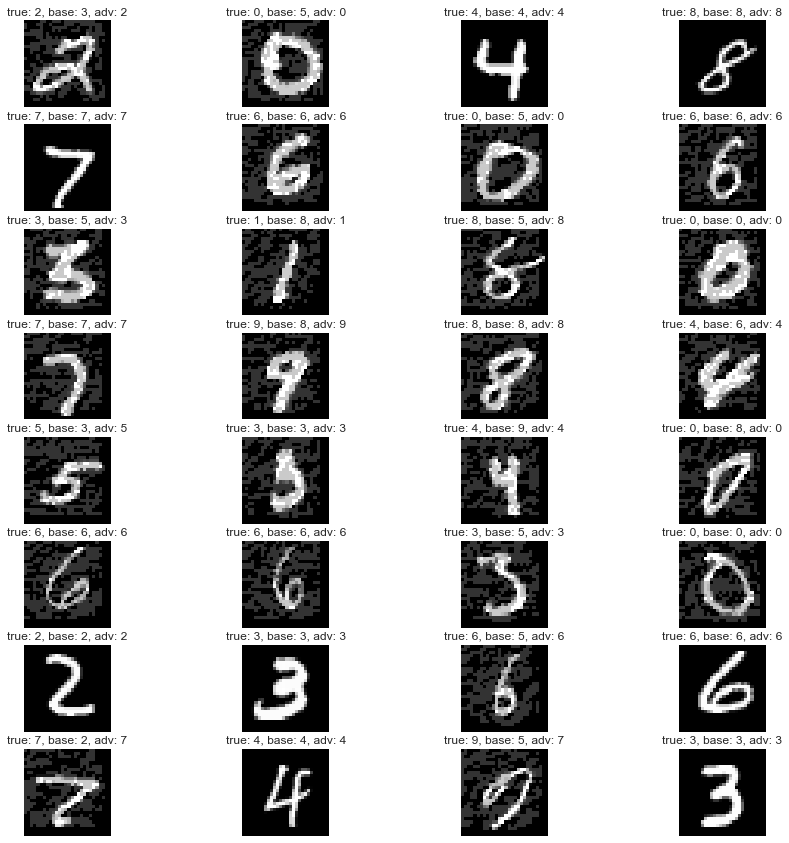

In [25]:
batch_index = 0

batch_image = perturbed_images[batch_index]
batch_label = labels[batch_index]
batch_pred = predictions[batch_index]

batch_size = HPARAMS.batch_size
n_col = 4
n_row = (batch_size + n_col - 1) / n_col

print('accuracy in batch %d:' % batch_index)
for name, pred in batch_pred.items():
  print('%s model: %d / %d' % (name, np.sum(batch_label == pred), batch_size))

plt.figure(figsize=(15, 15))
for i, (image, y) in enumerate(zip(batch_image, batch_label)):
  y_base = batch_pred['base'][i]
  y_adv = batch_pred['adv-regularized'][i]
  plt.subplot(n_row, n_col, i+1)
  plt.title('true: %d, base: %d, adv: %d' % (y, y_base, y_adv))
  plt.imshow(tf.keras.preprocessing.image.array_to_img(image), cmap='gray')
  plt.axis('off')

plt.show()